<a href="https://colab.research.google.com/github/mkbahk/QuantumComputing/blob/main/IonQ_%EC%96%91%EC%9E%90%ED%9A%8C%EB%A1%9C3_%EC%B8%A1%EC%A0%95.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install qiskit and qiskit-ionq if you need to
!python3 -m pip install qiskit
!python3 -m pip install qiskit-ionq

In [ ]:
# Imports
from qiskit_ionq import IonQProvider
ionq_provider = IonQProvider(token='sIdNYBF7UGuQj2LDYeYQbR2wpaxJJU4K')

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, execute
from qiskit.tools.visualization import plot_histogram
import numpy as np

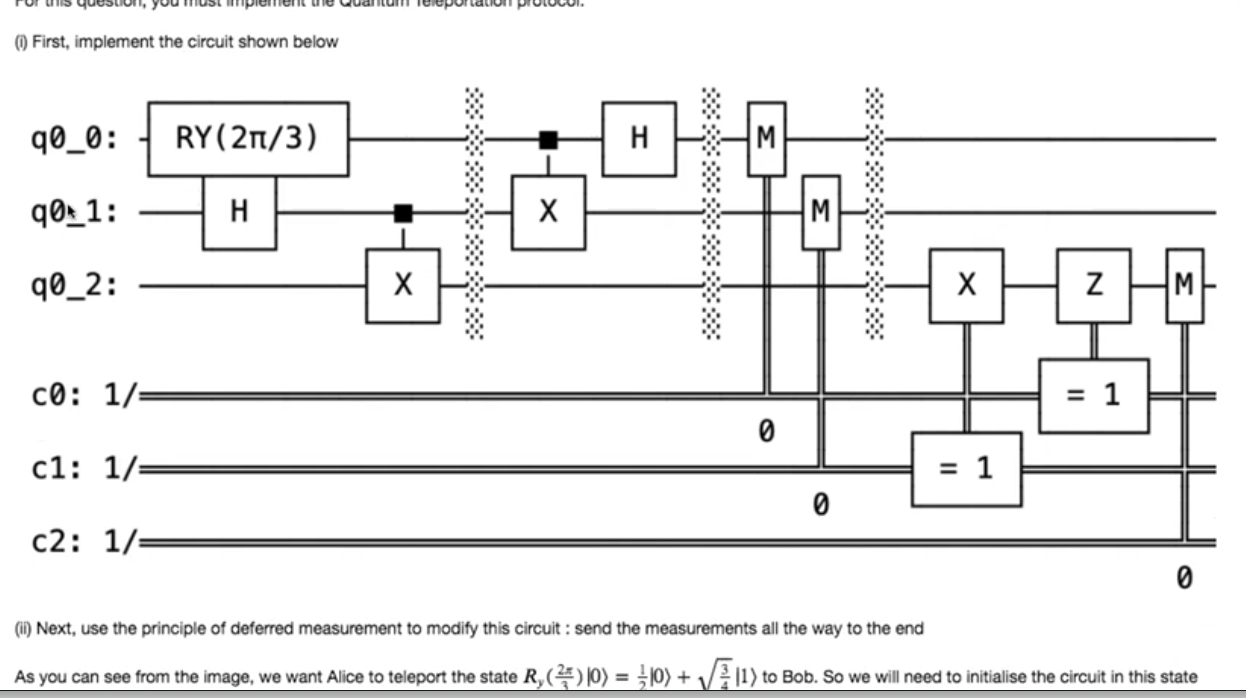

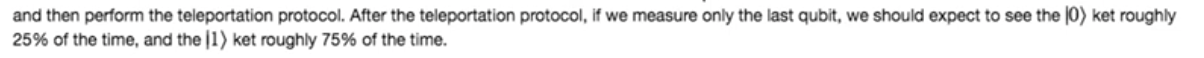

In [ ]:
# Implement the entangle function
def entangle(circuit, q1, q2):
  circuit.h(q1)
  circuit.cx(q1, q2)
###def

# Implement alice's function
def alice(circuit, q1, q2):
  circuit.cx(q1, q2)
  circuit.h(q1)
###def

# Implement bob's function
def bob(circuit, qubit, cr1, cr2):
  circuit.x(qubit).c_if(cr1, 1)
  circuit.z(qubit).c_if(cr2, 1)
###

# Implement the teleportation protocol
def teleport(initialization_circuit):
  #setup initial circuit
  quantum_register = QuantumRegister(3)
  classical_register_one = ClassicalRegister(1)
  classical_register_two = ClassicalRegister(1)
  classical_register_three = ClassicalRegister(1)
  circuit = QuantumCircuit(quantum_register, classical_register_one, classical_register_two, classical_register_three)
  circuit = circuit.compose(initialization_circuit, [0])

  #entangle qubits
  entangle(circuit, 1, 2)

  #Apply CNOT and Hadamard
  alice(circuit, 0, 1)

  #measure qubits 0, 1
  circuit.measure(0, 0)
  circuit.measure(1, 1)

  #Bob looks at classical bit
  bob(circuit, 2, classical_register_two, classical_register_one)

  circuit.measure(2, 2)

  return circuit
###def

In [ ]:
#Initialize the circuit to set the initial state
init_circuit = QuantumCircuit(1) #Initialize quantum circuit with one qubit
init_circuit.ry((np.pi / 3) * 2, 0) #apply the R_y rotation

#display the initialization circuit
print('Initialization Circuit...')
print(init_circuit.draw())

# get the telepotation circuit
circuit = teleport(init_circuit)
circuit.draw()

In [ ]:
# Plot the histogram of the counts
backend = Aer.get_backend('qasm_simulator')
job = execute(circuit, backend)
result = job.result()
counts = result.get_counts()
plot_histogram(counts)

This result is a little difficult to interpret because we don't really care about the first and second qubits: we just want to see if the last qubit is in the initial state we set the first qubit to. So we will process this histogram to show only the result of the last qubit.

In [ ]:
# plot the histogram of the counts of the last qubit only

last_qubit_counts = {'0': 0, '1': 0}

for key, val in counts.items():
  last_qubit_counts[key[0]] += val
###for

plot_histogram(last_qubit_counts)

This is the correct result

Now, let us use the principle of deferred measurement. We will shift our measurements to the very end of the circuit, and we will use the conditiaonal operations instead of checking the status of the classical bits.

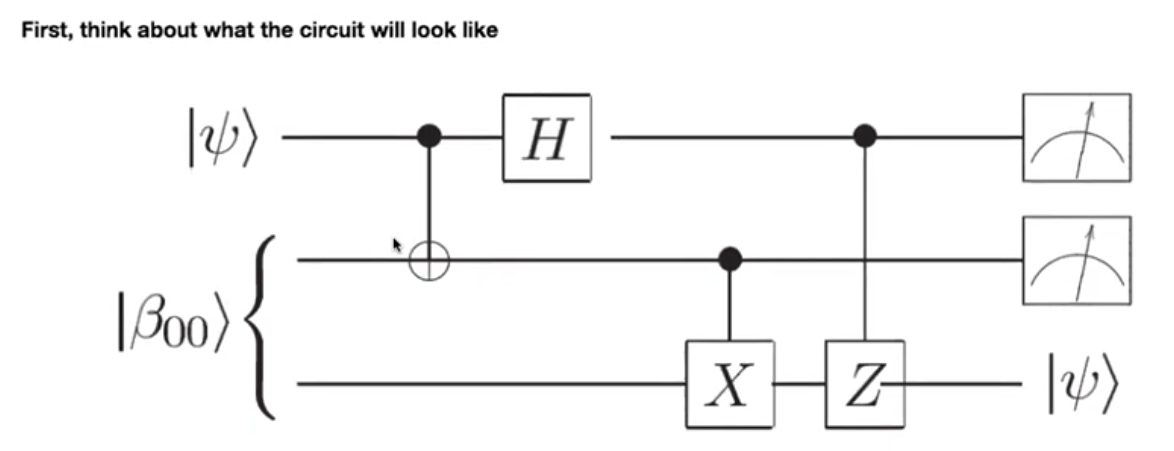

In [ ]:
# Change Bob's function
def bob(circuit):
  circuit.cx(1, 2)
  circuit.cz(0, 2)
###def

# Implement circuit with deferred measurement
def deferred_teleport(initialization_circuit):
  #setup initial circuit
  quantum_register = QuantumRegister(3)
  classical_register_one = ClassicalRegister(1)
  classical_register_two = ClassicalRegister(1)
  classical_register_three = ClassicalRegister(1)
  circuit = QuantumCircuit(quantum_register, classical_register_one, classical_register_two, classical_register_three)
  circuit = circuit.compose(initialization_circuit, [0])

  #entangle qubits
  entangle(circuit, 1, 2)

  #Apply CNOT and Hadamard
  alice(circuit, 0, 1)

  #Bob looks at classical bit
  bob(circuit)

  circuit.measure(2, 2)

  return circuit
###def

In [ ]:
# get the teleportation circuit
circuit = deferred_teleport(init_circuit)

# Execuite on IonQ hardware
backend = ionq_provider.get_backend('ionq_qpu') # Choose your backend
job = execute(circuit, backend) # get the job object
# Check if job is complete
from qiskit.providers.jobstatus import JobStatus
import time

while job.status() is not JobStatus.DONE:
  print(job.status())
  time.sleep(30)
###while

In [ ]:
# Plot the histogram of the counts of the last qubit
result = job.result()
counts = result.get_counts()


last_qubit_counts = {'0': 0, '1': 0}

for key, val in counts.items():
  last_qubit_counts[key[0]] += val
###for

plot_histogram(last_qubit_counts)

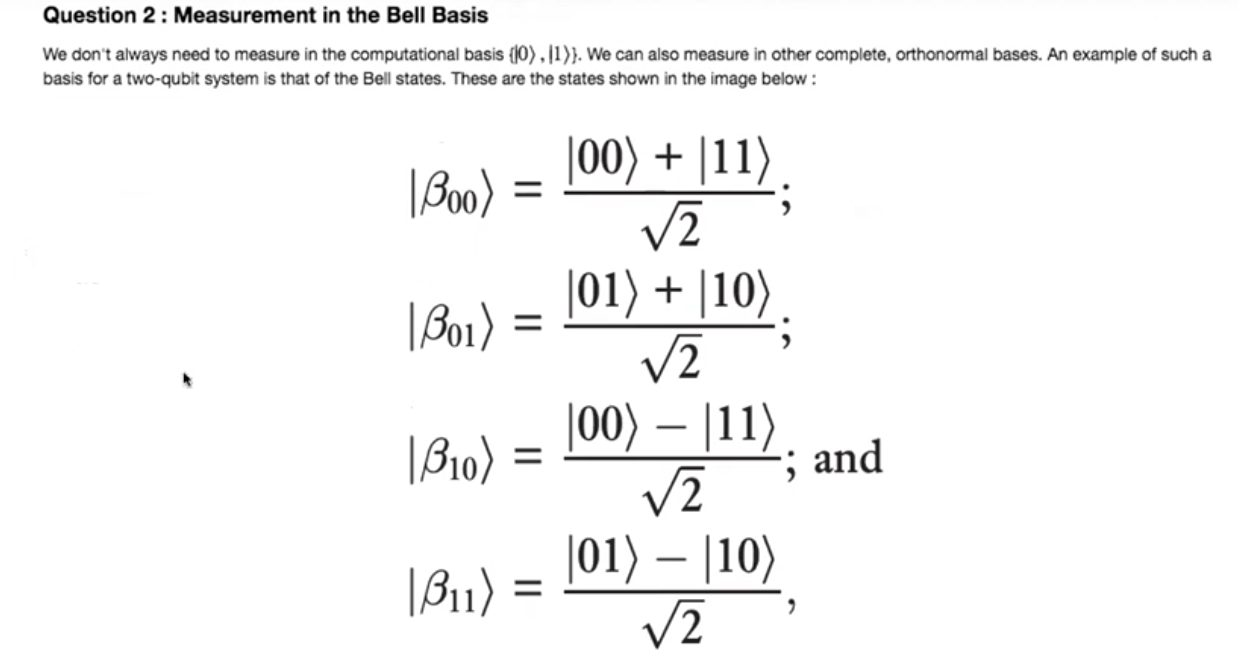

벨 기저(Bell basis)는 양자 컴퓨팅에서 중요한 기저 집합 중 하나로, 양자 두 개의 큐비트(양자 비트)를 사용하여 특별한 상태를 나타내는 기저를 말합니다. 벨 기저는 양자 컴퓨팅에서 양자 얽힘(quantum entanglement)과 양자 통신 등에 중요한 역할을 합니다.

벨 기저는 네 가지 서로 직교하는 양자 상태로 구성됩니다. 이 네 가지 벨 기저는 다음과 같이 표현됩니다:

1. |Φ⁺⟩ = (1/√2)(|00⟩ + |11⟩)
2. |Φ⁻⟩ = (1/√2)(|00⟩ - |11⟩)
3. |Ψ⁺⟩ = (1/√2)(|01⟩ + |10⟩)
4. |Ψ⁻⟩ = (1/√2)(|01⟩ - |10⟩)

여기서 각 상태는 큐비트의 상태를 나타내는 케트 표기법을 사용하여 표현되며, |ab⟩는 첫 번째 큐비트가 a 상태, 두 번째 큐비트가 b 상태를 가리킵니다. a와 b는 0 또는 1이 될 수 있습니다.

벨 기저는 양자 얽힘과 양자 통신을 연구하는데 매우 유용합니다. 예를 들어, 벨 상태는 한 큐비트에서 다른 큐비트로 정보를 전달하거나 양자 컴퓨터에서 양자 연산을 수행하는데 사용됩니다. 벨 상태의 특별한 특성은 양자 비트들 사이의 상호작용을 설명하는 데 도움이 됩니다. 또한 벨 기저는 양자 알고리즘의 구현에 있어서도 중요한 역할을 합니다.

양자컴퓨팅에서 벨 기저는 기존의 클래식 컴퓨터와는 다른 양자적 특성을 활용하여 복잡한 계산과 문제 해결에 활용되는데, 이는 양자 상태의 얽힘과 상호간의 상태 변화를 효과적으로 이용함으로써 이루어집니다.

양자컴퓨터에서 벨 기저(Bell basis)는 두 개의 큐비트(qubit)의 상태를 나타내는 기저입니다. 벨 기저는 다음과 같이 네 가지 상태로 구성됩니다.

| 상태 | 표현 |
|---|---|
| 벨 + | |
| 벨 - | |
| 벨 ↑↓ | |
| 벨 ↓↑ | |

벨 + 상태는 두 개의 큐비트가 모두 0 상태에 있는 상태입니다. 벨 - 상태는 두 개의 큐비트가 모두 1 상태에 있는 상태입니다. 벨 ↑↓ 상태는 두 개의 큐비트가 서로 반대인 상태에 있는 상태입니다. 벨 ↓↑ 상태는 두 개의 큐비트가 서로 반대인 상태에 있는 상태입니다.

벨 기저는 양자 얽힘(quantum entanglement)의 특성을 나타냅니다. 얽힌 상태에 있는 두 개의 큐비트는 서로의 상태를 서로 영향을 미칩니다. 예를 들어, 하나의 큐비트를 측정하면 다른 큐비트의 상태가 결정됩니다.

벨 기저는 양자컴퓨터에서 중요한 역할을 합니다. 벨 기저를 사용하여 양자 연산을 수행하고, 양자 통신을 수행하고, 양자 암호화 등을 수행할 수 있습니다.

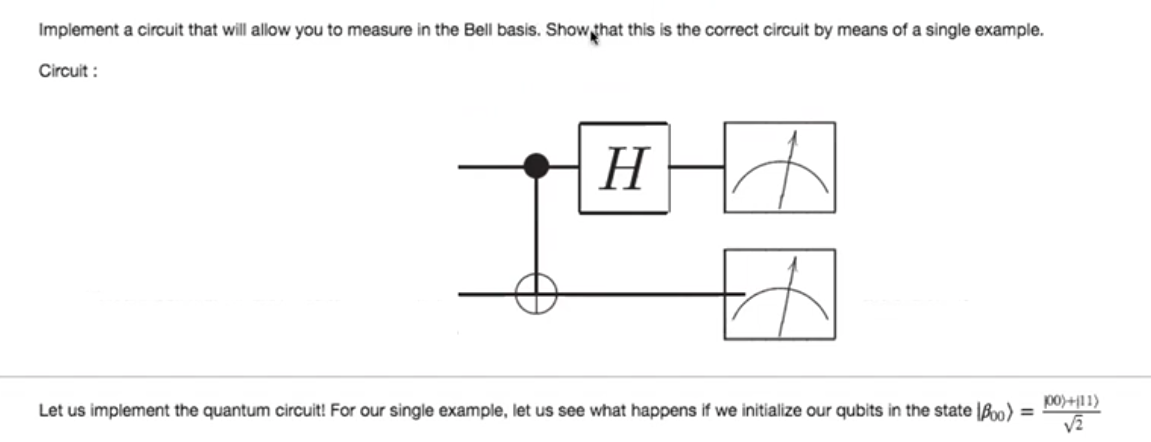

In [ ]:
# Initialise quantum circuit
qc = QuantumCircuit(2)

# Put in bell state beta_00
qc.h(0)
qc.cx(0, 1)

# Implement bell measurement circuit
qc.cx(0, 1)
qc.h(0)
qc.measure_all()

# Draw circuit
qc.draw('mpl')

위 회로에스 q0에 있는 H gate는 다음 H gate로 상쇄되고,
q1의 CNOT는 다음 CNOT으로 상쇄되어 항상 결과는 0, 0가 됩니다.

In [ ]:
# Get counts
backend  = Aer.get_backend('qasm_simulator')
job = execute(qc, backend)
counts = result.get_counts()
plot_histogram(counts)

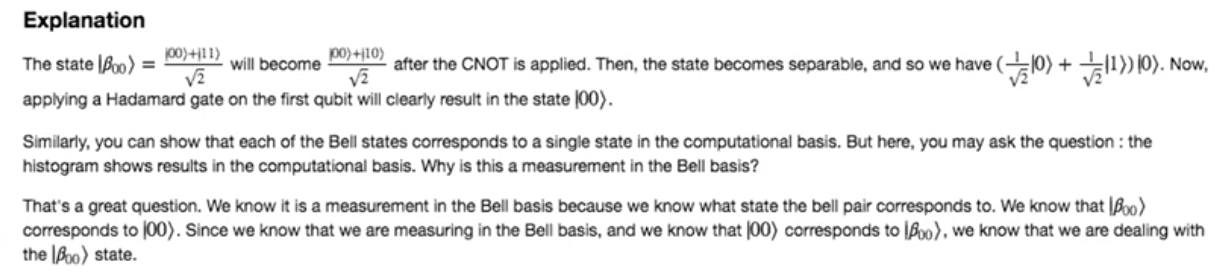